# Advanced Machine Learning @ UDD
### Instructor: Visiting Professor Rossano Schifanella

# Linear models
Linear models are useful when little data is available or for very large feature spaces as in text classification. In addition, they form a good case study for regularization.

# Linear models for regression

All linear models for regression learn a coefficient parameter ``coef_`` and an offset ``intercept_`` to make predictions using a linear combination of features:

```
y_pred = x_test[0] * coef_[0] + ... + x_test[n_features-1] * coef_[n_features-1] + intercept_
```

The difference between the linear models for regression is what kind of restrictions or penalties are put on ``coef_`` as regularization , in addition to fitting the training data well.
The most standard linear model is the 'ordinary least squares regression', often simply called 'linear regression'. It doesn't put any additional restrictions on ``coef_``, so when the number of features is large, it becomes ill-posed and the model overfits.

Let us generate a simple simulation, to see the behavior of these models.

In [1]:
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

% matplotlib inline

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()


In [3]:
from sklearn.utils import shuffle
X, y = boston.data, boston.target

In [4]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

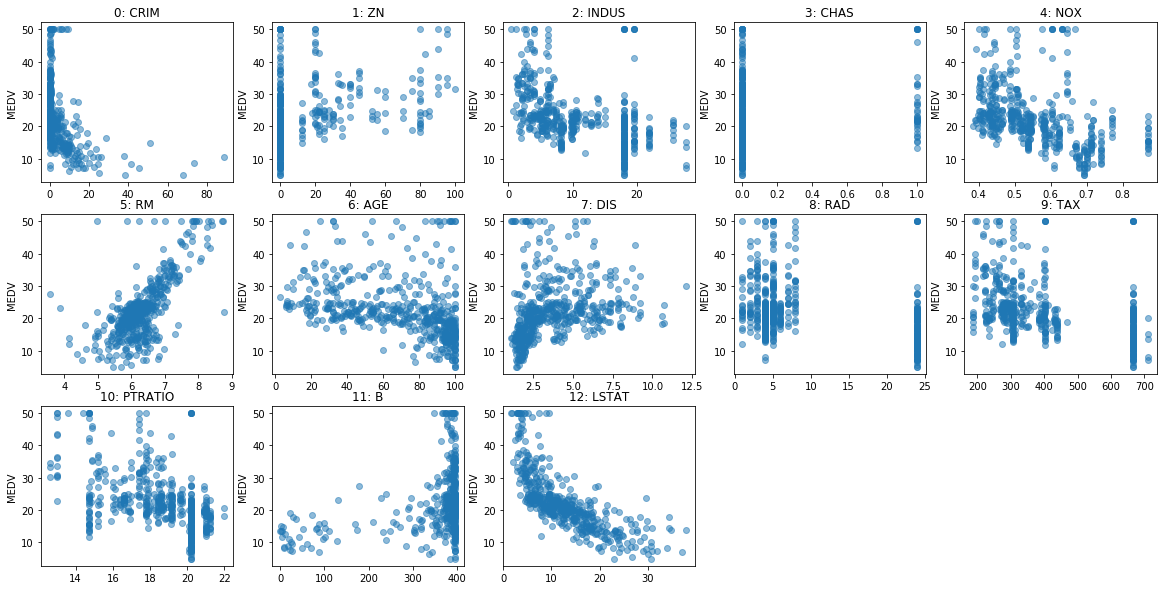

In [5]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    if i > 12:
        ax.set_visible(False)
        continue
    ax.plot(X[:, i], y, 'o', alpha=.5)
    ax.set_title("{}: {}".format(i, boston.feature_names[i]))
    ax.set_ylabel("MEDV")

In [6]:
print(X.shape)
print(y.shape)

(506, 13)
(506,)


## Linear Regression


In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

### Simple example

In [8]:
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
# Create linear regression object
linear_regressor = LinearRegression()

# Train the model using the training sets
linear_regressor.fit(X_train, y_train)

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, linear_regressor.predict(X_test)))
# Explained variance score: 1 is perfect prediction
print('R^2 (training): %f' % r2_score(y_train, linear_regressor.predict(X_train)))
print('R^2 (testing): %f' % r2_score(y_test, linear_regressor.predict(X_test)))

Coefficients: 
 [-1.28322638e-01  2.95517751e-02  4.88590934e-02  2.77350326e+00
 -1.62388292e+01  4.36875476e+00 -9.24808158e-03 -1.40086668e+00
  2.57761243e-01 -9.95694820e-03 -9.23122944e-01  1.31854199e-02
 -5.17639519e-01]
Mean squared error: 22.10
R^2 (training): 0.748087
R^2 (testing): 0.684427


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


### Plotting Cross-Validated Predictions

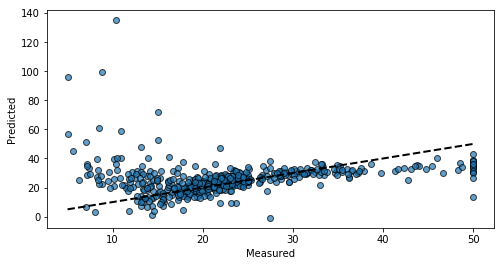

In [10]:
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(linear_regressor, X, y, cv=3)

fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(y, predicted, edgecolors=(0, 0, 0), marker='o', alpha=0.7)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [11]:
results = cross_val_score(linear_regressor, X_train, y_train, cv=10)
print(results)
print("mean: ", np.mean(results))


[0.7832738  0.70313102 0.55559062 0.7328346  0.82883292 0.699766
 0.80487399 0.71770265 0.78880787 0.54531972]
mean:  0.7160133196648378


### Plotting learning curve

<Figure size 432x288 with 0 Axes>

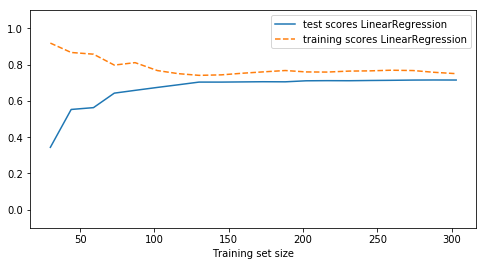

In [12]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(est, X, y):
    training_set_size, train_scores, test_scores = learning_curve(est, X, y, cv=5, train_sizes=np.linspace(.1, 1, 20))
    estimator_name = est.__class__.__name__
    
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(training_set_size, test_scores.mean(axis=1), '-', label="test scores " + estimator_name)
    ax.plot(training_set_size, train_scores.mean(axis=1), '--', label="training scores " + estimator_name)
    ax.set_xlabel('Training set size');    
    ax.set_ylim(-0.1, 1.1)
    plt.legend(loc='best')

plt.figure()   
plot_learning_curve(LinearRegression(), X_train, y_train)

## Ridge Regression (L2 penalty)

**The Ridge estimator** is a simple regularization (called l2 penalty) of the ordinary LinearRegression. In particular, it has the benefit of being not computationally more expensive than the ordinary least square estimate.

$$ \text{min}_{w,b}  \sum_i || w^\mathsf{T}x_i + b  - y_i||^2  + \alpha ||w||_2^2$$ 

The amount of regularization is set via the `alpha` parameter of the Ridge.

In [13]:
# Create linear regression object
ridge_regressor = Ridge()

# Train the model using the training sets
ridge_regressor.fit(X_train, y_train)

# The coefficients
print('Coefficients: \n', ridge_regressor.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, ridge_regressor.predict(X_test)))
# Explained variance score: 1 is perfect prediction
print('R^2 (training): %f' % r2_score(y_train, ridge_regressor.predict(X_train)))
print('R^2 (testing): %f' % r2_score(y_test, ridge_regressor.predict(X_test)))

Coefficients: 
 [-0.12383039  0.03139178  0.01767668  2.54277179 -8.77249222  4.37980204
 -0.01537349 -1.29086084  0.24406848 -0.01082435 -0.83346553  0.01348642
 -0.53435396]
Mean squared error: 22.48
R^2 (training): 0.746116
R^2 (testing): 0.678975


### Tuning the hyperparameter alpha

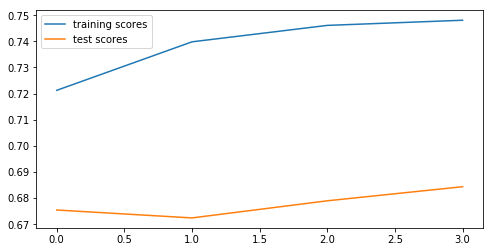

In [14]:
ridge_models = {}
training_scores = []
test_scores = []

for alpha in [100, 10, 1, .01]:
    ridge = Ridge(alpha=alpha).fit(X_train, y_train)
    training_scores.append(ridge.score(X_train, y_train))
    test_scores.append(ridge.score(X_test, y_test))
    ridge_models[alpha] = ridge
    
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(training_scores, label="training scores")
ax.plot(test_scores, label="test scores")
ax.set_xticks(range(4), [100, 10, 1, .01])
plt.legend(loc='best')    


Tuning alpha is critical for performance.

### Using GridSearchCV to set the best alpha 

In [15]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': np.logspace(-3, 3, 14)}
print(param_grid)

grid_search = GridSearchCV(Ridge(), param_grid, cv=10, return_train_score=True, iid=False)
grid_search.fit(X_train, y_train)

print("Test set score: {:.4f}".format(grid_search.score(X_test, y_test)))

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))
print('Accuracy on the testing set: {:.4f}'.format(grid_search.best_estimator_.score(X_test, y_test)))

{'alpha': array([1.00000000e-03, 2.89426612e-03, 8.37677640e-03, 2.42446202e-02,
       7.01703829e-02, 2.03091762e-01, 5.87801607e-01, 1.70125428e+00,
       4.92388263e+00, 1.42510267e+01, 4.12462638e+01, 1.19377664e+02,
       3.45510729e+02, 1.00000000e+03])}
Test set score: 0.6840
Best parameters: {'alpha': 0.07017038286703829}
Best cross-validation score: 0.72
Best estimator:
Ridge(alpha=0.07017038286703829, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)
Accuracy on the testing set: 0.6840


## Lasso (L1 penalty)
**The Lasso estimator** is useful to impose sparsity on the coefficient. In other words, it is to be prefered if we believe that many of the features are not relevant. This is done via the so-called l1 penalty.

$$ \text{min}_{w, b} \sum_i \frac{1}{2} || w^\mathsf{T}x_i + b  - y_i||^2  + \alpha ||w||_1$$ 

In [16]:
param_grid = {'alpha': np.logspace(-1.5, 0, 14)}

print(param_grid)

grid_search = GridSearchCV(Lasso(), param_grid, cv=10, return_train_score=True, iid=False)
grid_search.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))
print('Accuracy on the testing set: {:.4f}'.format(grid_search.best_estimator_.score(X_test, y_test)))

{'alpha': array([0.03162278, 0.04124626, 0.05379838, 0.07017038, 0.09152473,
       0.11937766, 0.15570684, 0.20309176, 0.26489693, 0.34551073,
       0.45065703, 0.58780161, 0.76668221, 1.        ])}
Test set score: 0.68
Best parameters: {'alpha': 0.03162277660168379}
Best cross-validation score: 0.71
Best estimator:
Lasso(alpha=0.03162277660168379, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Accuracy on the testing set: 0.6756


Instead of picking Ridge *or* Lasso, you can also use [ElasticNet](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html), which uses both forms of regularization and provides a parameter to assign a weighting between them. ElasticNet typically performs the best amongst these models.

# Exercise
Load the diabetes dataset using ``sklearn.datasets.load_diabetes``. Apply ``LinearRegression``, ``Ridge`` and ``Lasso`` and visualize the coefficients. Try polynomial features.

In [17]:
# %load solutions/linear_models_diabetes.py

# Robust models (advanced - optional)

In [18]:
from sklearn.linear_model import HuberRegressor, RANSACRegressor

In [19]:
from sklearn.datasets import make_regression

n_samples = 1000
n_outliers = 50

X, y, coef = make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
model = LinearRegression()
model.fit(X, y)

line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = model.predict(line_X)

Text(0,0.5,'response')

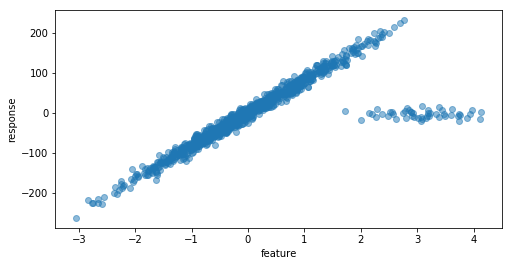

In [20]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(X, y, alpha=.5)
ax.set_xlabel("feature")
ax.set_ylabel("response")

Text(0,0.5,'response')

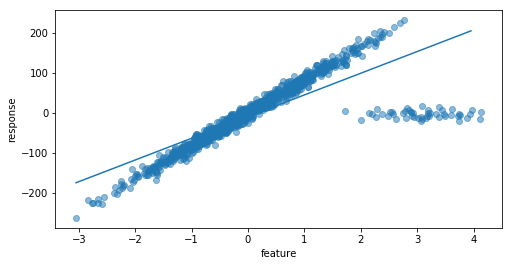

In [21]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(X, y, alpha=.5)
ax.plot(line_X, line_y, label="Linear Regression fit")
ax.set_xlabel("feature")
ax.set_ylabel("response")


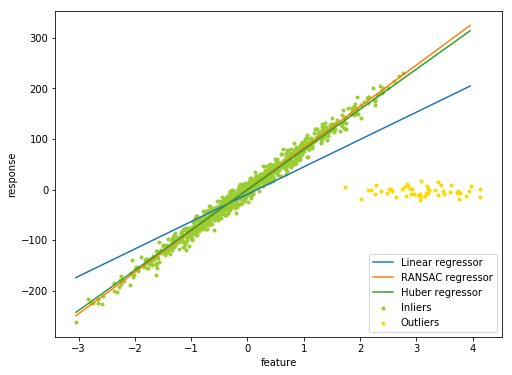

In [22]:
ransac_model = RANSACRegressor()

ransac_model.fit(X, y)
inlier_mask = ransac_model.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

huber_model = HuberRegressor().fit(X, y)

line_y_ransac = ransac_model.predict(line_X)
line_y_huber = huber_model.predict(line_X)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
ax.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
ax.plot(line_X, line_y, label='Linear regressor')
ax.plot(line_X, line_y_ransac, label='RANSAC regressor')
ax.plot(line_X, line_y_huber, label='Huber regressor')
ax.set_xlabel("feature")
ax.set_ylabel("response")
plt.legend(loc='lower right')